# Plot results from Streamlit expert eval app

## Setup

In [13]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import re


In [14]:
# config

# results file path
FILE = Path("/midtier/paetzollab/scratch/ads4015/ssl_streamlit/segmentation_eval_results - Responses_02112026_1529.csv")

# columns needed from results file
NEEDED_COLS = [
    "response_id","timestamp","user_id","sample_id","datatype","z",
    "rankA","rankB","rankC","map_A","map_B","map_C"
]

# rank (mean score, higher is better: best=2, middle=1, worst=0)
RANK_TO_SCORE = {"Best": 2, "Middle": 1, "Worst": 0}
RANK_ORDER = ["Best", "Middle", "Worst"]

# parse ntr (num train samples) from sample_id, ex: "..._size5_..." -> 5
NTR_REGEX = r"_size(\d+)_"

# plotting toggles
PLOT_OVERALL = True
PLOT_BY_NTR = False # ex., ntr5 vs ntr15
PLOT_BY_DATATYPE = False
PLOT_BY_USER = False

# filter users; if INCLUDE_USERS is non-empty, ONLY those users are used
INCLUDE_USERS = []  # ex: ["Adi", "MW"]
EXCLUDE_USERS = ['Adina', 'anonymous', 'MW']  # e.g. ["anonymous"]

# consistent model ordering across plots
# if empty, will auto-order by overall mean score (descending)
MODEL_ORDER = ["unet_image_clip", "unet_random", "microsam"]

# pretty x axis labels
MODEL_LABELS = {
    "unet_image_clip": "UNet I+T",
    "unet_random": "UNet R",
    "microsam": "uSAM",
}

# Keep ONLY the most recent submission for each (user_id, sample_id).
DEDUPE_KEEP_MOST_RECENT_PER_USER_SAMPLE = True


## Helper functions

In [15]:
# i/o parsing

# function to read responses file into dataframe
def read_responses(path: Path, needed_cols: list[str]) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    # auto-detect delimiter by first line
    with open(path, "r", encoding="utf-8") as f:
        first_line = f.readline()
    sep = "\t" if "\t" in first_line else ","

    df = pd.read_csv(path, sep=sep, dtype=str, keep_default_na=False)
    df.columns = [c.strip() for c in df.columns]

    missing = [c for c in needed_cols if c not in df.columns]
    if missing:
        raise ValueError(
            f"Missing columns: {missing}\n"
            f"Found: {list(df.columns)}"
        )

    # strip whitespace
    for c in needed_cols:
        df[c] = df[c].astype(str).str.strip()

    # Parse timestamp to datetime for sorting/deduping
    # CSV looks like: "2026-01-26 06:05:49"
    df["timestamp_dt"] = pd.to_datetime(df["timestamp"], errors="coerce")

    df["z"] = pd.to_numeric(df["z"], errors="coerce")
    return df


# function to extract ntr from sample_id
def extract_ntr(sample_id: str, regex: str = NTR_REGEX):
    m = re.search(regex, str(sample_id))
    return int(m.group(1)) if m else np.nan


# function to get total number of points
def _npoints(sub: pd.DataFrame) -> int:
    # each row in `sub` is one (response, model) rating
    return int(len(sub))


# function to convert wide to long format
def wide_to_long(df_wide: pd.DataFrame, rank_to_score: dict) -> pd.DataFrame:
    rows = []
    for _, r in df_wide.iterrows():
        for lab in ["A", "B", "C"]:
            model = str(r[f"map_{lab}"]).strip()
            rank = str(r[f"rank{lab}"]).strip()
            if rank not in rank_to_score:
                continue
            rows.append({
                "response_id": r["response_id"],
                "timestamp": r["timestamp"],
                "timestamp_dt": r.get("timestamp_dt", pd.NaT),
                "user_id": r["user_id"],
                "sample_id": r["sample_id"],
                "datatype": r["datatype"],
                "z": r["z"],
                "ntr": r["ntr"],
                "label": lab,
                "model": model,
                "rank": rank,
                "score": rank_to_score[rank],
            })
    long = pd.DataFrame(rows)
    return long


In [16]:
# filtering

# function to filter dataframe by users, if specified
def filter_users(df: pd.DataFrame, include_users=None, exclude_users=None) -> pd.DataFrame:
    include_users = include_users or []
    exclude_users = exclude_users or []

    out = df.copy()
    if len(include_users) > 0:
        out = out[out["user_id"].isin(include_users)]
    elif len(exclude_users) > 0:
        out = out[~out["user_id"].isin(exclude_users)]
    return out.reset_index(drop=True)


# function to generate filter suffix for plot titles
def _filter_suffix(include_users, exclude_users) -> str:
    if include_users:
        return f"(users={include_users})"
    if exclude_users:
        return f"(excluding={exclude_users})" # uncomment to add suffix
        return
    return "(all users)"


# dedupe (keep only the most recent row for each (user_id, sample_id))
def keep_most_recent_per_user_sample(df_wide: pd.DataFrame) -> pd.DataFrame:

    if len(df_wide) == 0:
        return df_wide

    out = df_wide.copy()

    # put NaT last so real timestamps win
    out = out.sort_values(["user_id", "sample_id", "timestamp_dt"], ascending=[True, True, True])

    # keep last (most recent) within each (user_id, sample_id)
    out = out.drop_duplicates(subset=["user_id", "sample_id"], keep="last")
    return out.reset_index(drop=True)


In [17]:
# summary and plotting

# function to plot rank fractions stacked bar plot
def plot_rank_fractions(data: pd.DataFrame, title: str, model_order: list[str]):
    if len(data) == 0:
        print(f"[SKIP] {title}: no data")
        return

    ct = (data.groupby(["model", "rank"])
              .size()
              .unstack("rank", fill_value=0))

    for rk in RANK_ORDER:
        if rk not in ct.columns:
            ct[rk] = 0
    ct = ct[RANK_ORDER].reindex(model_order).dropna(how="all")

    frac = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0)

    npts = _npoints(data)
    plt.figure(figsize=(7.2, 3.8))
    bottom = np.zeros(len(frac))
    x = np.arange(len(frac.index))

    # rank colors
    RANK_COLORS = {
        "Best": "#1b9e77",
        "Middle": "#7570b3",
        "Worst": "#d95f02",
    }

    for rk in RANK_ORDER:
        vals = frac[rk].fillna(0).values
        plt.bar(x, vals, bottom=bottom, label=rk, color=RANK_COLORS.get(rk, None))
        bottom += vals

    plt.ylim(0, 1)
    plt.ylabel("Fraction of ratings")

    # no tilt: horizontal labels with pretty names
    labels = [MODEL_LABELS.get(m, m) for m in list(frac.index)]
    plt.xticks(x, labels, rotation=0, ha="center")

    # legend outside right
    plt.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
    )
    plt.tight_layout()

    plt.show()

# function to plot a block of plots + optional summary table
def plot_block(data: pd.DataFrame, title: str, model_order: list[str]):
    plot_rank_fractions(data, f"{title} — Rank fractions", model_order)
    


[DEDUP] wide: 587 -> 540 (dropped 47 older duplicates)
Loaded responses (wide): 540
Expanded (long): 1620
Users: ['Adina', 'Brian E', 'Erica Bulzomi', 'Haotan Zhang', 'Johannes', 'MW', 'Zhuhao Wu', 'anonymous', 'mu']
Datatypes: ['amyloid_plaque', 'cell_nucleus', 'vessels']
NTRs: [5, 15]
User filtering: 1620 rows -> 1080 rows (excluding=['Adina', 'anonymous', 'MW'])
Users included: ['Brian E', 'Erica Bulzomi', 'Haotan Zhang', 'Johannes', 'Zhuhao Wu', 'mu']


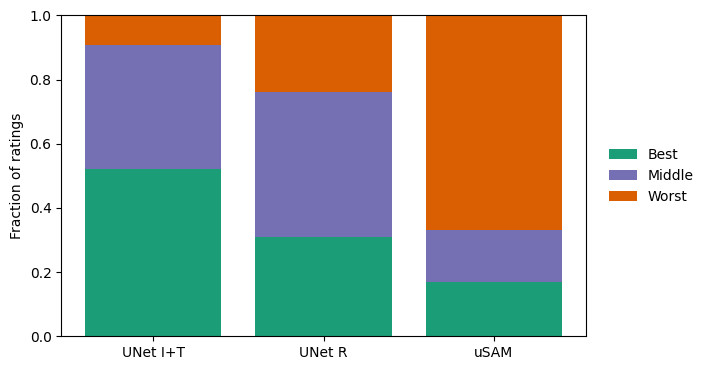

In [18]:
# run

# read data
df = read_responses(FILE, NEEDED_COLS)
df["ntr"] = df["sample_id"].apply(extract_ntr)

# if specified, keep only most recent response per (user_id, sample_id)
if DEDUPE_KEEP_MOST_RECENT_PER_USER_SAMPLE:
    before = len(df)
    df = keep_most_recent_per_user_sample(df)
    after = len(df)
    dropped = before - after
    print(f"[DEDUP] wide: {before} -> {after} (dropped {dropped} older duplicates)")

long = wide_to_long(df, RANK_TO_SCORE)

print("Loaded responses (wide):", len(df))
print("Expanded (long):", len(long))
print("Users:", sorted(long["user_id"].unique()))
print("Datatypes:", sorted(long["datatype"].unique()))
print("NTRs:", sorted([int(x) for x in long["ntr"].dropna().unique()]))

# filter users
long_filt = filter_users(long, include_users=INCLUDE_USERS, exclude_users=EXCLUDE_USERS)
suffix = _filter_suffix(INCLUDE_USERS, EXCLUDE_USERS)

print(f"User filtering: {len(long)} rows -> {len(long_filt)} rows {suffix}")
print("Users included:", sorted(long_filt["user_id"].unique()))

# fixed order: UNet I+T, UNet R, uSAM (only keep those present)
present = set(long_filt["model"].unique())
GLOBAL_MODEL_ORDER = [m for m in MODEL_ORDER if m in present]

# plot overall (optionally filtered, if specified)
if PLOT_OVERALL:
    plot_block(long_filt, f"OVERALL {suffix}", GLOBAL_MODEL_ORDER)

# plot by ntr (optionally filtered, if specified)
if PLOT_BY_NTR:
    for ntr in sorted([int(x) for x in long_filt["ntr"].dropna().unique()]):
        sub = long_filt[long_filt["ntr"] == ntr]
        if len(sub) == 0:
            continue
        plot_block(sub, f"BY NTR: ntr{ntr} {suffix}", GLOBAL_MODEL_ORDER)

# plot by datatype (optionally filtered, if specified)
if PLOT_BY_DATATYPE:
    for dtype in sorted(long_filt["datatype"].dropna().unique()):
        sub = long_filt[long_filt["datatype"] == dtype]
        if len(sub) == 0:
            continue
        plot_block(sub, f"BY DATATYPE: {dtype} {suffix}", GLOBAL_MODEL_ORDER)

# plot by user (optionally filtered, if specified)
if PLOT_BY_USER:
    for u in sorted(long_filt["user_id"].dropna().unique()):
        sub = long_filt[long_filt["user_id"] == u]
        if len(sub) == 0:
            continue
        plot_block(sub, f"BY USER: {u} {suffix}", GLOBAL_MODEL_ORDER)
